In [2]:
# Import libraries

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

In [3]:
# Set timeframe and define tickers

years = 15

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [6]:
# Download adjusted close price and calculate log returns

adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']
    
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-02-18 -0.002401 -0.003880  0.015180  0.000684 -0.003298
2009-02-19 -0.010813 -0.004286 -0.011833 -0.015509 -0.010728
2009-02-20 -0.009769  0.001820  0.020975  0.002775 -0.011883
2009-02-23 -0.036435  0.001688 -0.000716 -0.035611 -0.034637
2009-02-24  0.037209 -0.000778 -0.031178  0.032489  0.035676
...              ...       ...       ...       ...       ...
2024-02-07  0.008306 -0.001926 -0.000265  0.010238  0.007851
2024-02-08  0.000442 -0.002620 -0.000902  0.001850  0.002469
2024-02-09  0.005763 -0.000829 -0.003884  0.009795  0.006085
2024-02-12 -0.000439  0.000276 -0.002615 -0.003920  0.000964
2024-02-13 -0.013869 -0.008741 -0.013885 -0.015720 -0.016145

[3773 rows x 5 columns]


In [9]:
# Create equally weighted portfolio and calculate historical returns

portfolio_value = 1000000
weights = np.array([1/len(tickers)] * len(tickers))

historical_returns = (log_returns * weights).sum(axis=1)

print(historical_returns)

Date
2009-02-18    0.001257
2009-02-19   -0.010634
2009-02-20    0.000784
2009-02-23   -0.021142
2009-02-24    0.014684
                ...   
2024-02-07    0.004841
2024-02-08    0.000248
2024-02-09    0.003386
2024-02-12   -0.001147
2024-02-13   -0.013672
Length: 3773, dtype: float64


In [11]:
# Find X-Day historical returns

days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum().dropna()

print(historical_x_day_returns)

Date
2009-02-24   -0.015052
2009-02-25   -0.025157
2009-02-26   -0.027734
2009-02-27   -0.039456
2009-03-02   -0.046996
                ...   
2024-02-07    0.017377
2024-02-08    0.006735
2024-02-09    0.006670
2024-02-12    0.010164
2024-02-13   -0.006344
Length: 3769, dtype: float64


In [16]:
# Create covariance matrix and calculate portfolio standard deviation

cov_matrix = log_returns.cov() * 252 # 252 business days in a year
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights) # @ is used for matrix multiplication

print(cov_matrix)
print(portfolio_std_dev)

          SPY       BND       GLD       QQQ       VTI
SPY  0.031859 -0.000122  0.001486  0.034362  0.032508
BND -0.000122  0.002332  0.002257  0.000109 -0.000076
GLD  0.001486  0.002257  0.024848  0.001628  0.001615
QQQ  0.034362  0.000109  0.001628  0.043232  0.035142
VTI  0.032508 -0.000076  0.001615  0.035142  0.033449
0.11891807380064448


In [18]:
# Calculate VaR at different confidence levels

from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []

for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)


In [19]:
# Print VaR Results

print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $-23,602.29
    95%:          $-29,687.85
    99%:          $-41,103.35


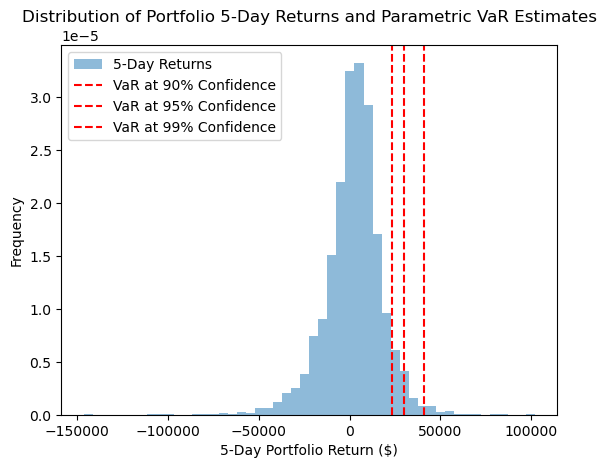

In [21]:
# Plot the distribution of portfolio returns and Parametric VaR estimate
import matplotlib.pyplot as plt

# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()